In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.random import uniform
from scipy.stats import loguniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC

### Plotting the log-uniform distribution

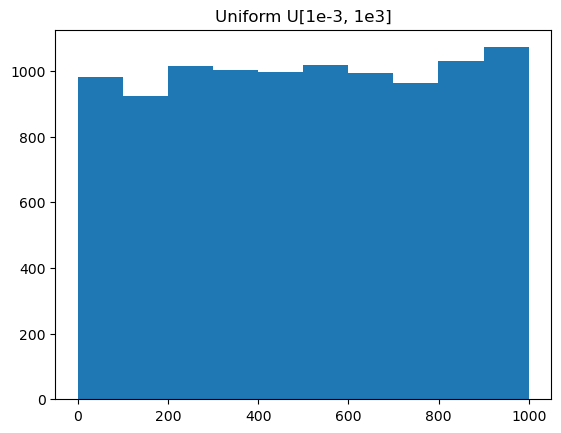

In [2]:
a, b, size = 1e-3, 1e3, 10000 
u = uniform(a, b, size)
fig, ax = plt.subplots()
ax.hist(u)
ax.set_title("Uniform U[1e-3, 1e3]")
plt.show()

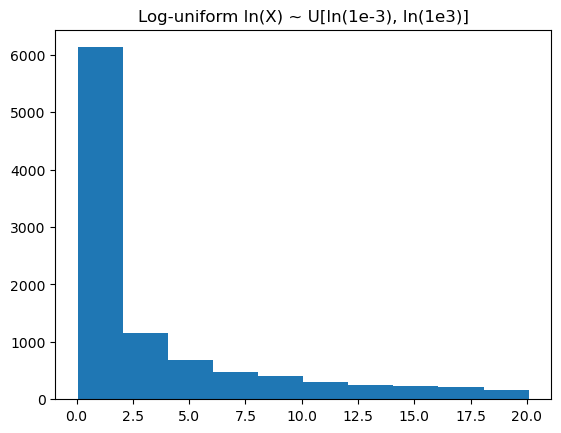

In [3]:
fig, ax = plt.subplots()
a, b, size = np.e**-3, np.e**3, 10000
u = uniform(np.log(a), np.log(b), size)
ax.hist(np.exp(u))
ax.set_title("Log-uniform ln(X) ~ U[ln(1e-3), ln(1e3)]")
plt.show()

## Hyper-parameter tuning problems

In [4]:
def make_synthetic_dataset(n_features=50, n_informative=10, n_redundant=15, n_samples=10000):
    from sklearn.datasets import make_classification
    # n_informative features, followed by n_redundant, followed by n_repeated duplicates
    X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative,\
                               n_redundant=n_redundant, shuffle=False, random_state=1711)
    cols = []
    n_noise = n_features - n_informative - n_redundant
    for i in range(n_informative):
        cols.append("I" + str(i))
    for i in range(n_redundant):
        cols.append("R" + str(i))
    for i in range(n_noise):
        cols.append("N" + str(i))

    X_df = pd.DataFrame(data=X, columns=cols)
    Y_series = pd.Series(y)
    
    return X_df, Y_series

In [5]:
n_features = 10
n_informative = 5
n_redundant = 0
n_samples = 10000

X, y = make_synthetic_dataset(n_features, n_informative, n_redundant, n_samples)

#### Grid Search for C and gamma for SVC with RBF kernel

In [6]:
n_folds = 10
param_grid = {'C':[1E-2,1E-1,1,10,100],
              'gamma':[1E-2,1E-1,1,10,100]}

grid_svc = SVC(kernel='rbf', probability=True)
grid_clf = GridSearchCV(estimator=grid_svc, param_grid=param_grid, scoring='neg_log_loss', n_jobs=-1, cv=n_folds, verbose=10)

In [7]:
%%time
grid_clf.fit(X, y)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10; 1/25] START C=0.01, gamma=0.01........................................
[CV 1/10; 1/25] END ........C=0.01, gamma=0.01;, score=-0.570 total time=  11.3s
[CV 3/10; 2/25] START C=0.01, gamma=0.1.........................................
[CV 3/10; 2/25] END .........C=0.01, gamma=0.1;, score=-0.451 total time=  11.1s
[CV 8/10; 2/25] START C=0.01, gamma=0.1.........................................
[CV 8/10; 2/25] END .........C=0.01, gamma=0.1;, score=-0.363 total time=  11.9s
[CV 7/10; 3/25] START C=0.01, gamma=1...........................................
[CV 7/10; 3/25] END ...........C=0.01, gamma=1;, score=-0.693 total time=  13.5s


/Users/khoihd/miniconda3/envs/khoihd/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/10; 1/25] START C=0.01, gamma=0.01........................................
[CV 3/10; 1/25] END ........C=0.01, gamma=0.01;, score=-0.628 total time=  11.0s
[CV 10/10; 1/25] START C=0.01, gamma=0.01.......................................
[CV 10/10; 1/25] END .......C=0.01, gamma=0.01;, score=-0.465 total time=  11.5s
[CV 9/10; 2/25] START C=0.01, gamma=0.1.........................................
[CV 9/10; 2/25] END .........C=0.01, gamma=0.1;, score=-0.356 total time=  12.0s
[CV 8/10; 3/25] START C=0.01, gamma=1...........................................
[CV 8/10; 3/25] END ...........C=0.01, gamma=1;, score=-0.693 total time=  13.6s
[CV 6/10; 1/25] START C=0.01, gamma=0.01........................................
[CV 6/10; 1/25] END ........C=0.01, gamma=0.01;, score=-0.454 total time=  11.7s
[CV 6/10; 2/25] START C=0.01, gamma=0.1.........................................
[CV 6/10; 2/25] END .........C=0.01, gamma=0.1;, score=-0.363 total time=  11.5s
[CV 4/10; 3/25] START C=0.01

GridSearchCV(cv=10, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_log_loss', verbose=10)

In [8]:
print("The best CV estimator: {}".format(grid_clf.best_estimator_))
print("The best CV score: {:.2f}".format(grid_clf.best_score_))

The best CV estimator: SVC(C=10, gamma=0.1, probability=True)
The best CV score: -0.20


#### Randomized Search with log-uniform distributions for C and gamma for SVC with RBF kernel

Generate Log-uniform distribution log(X) ~ Uniform(log(a), log(b))

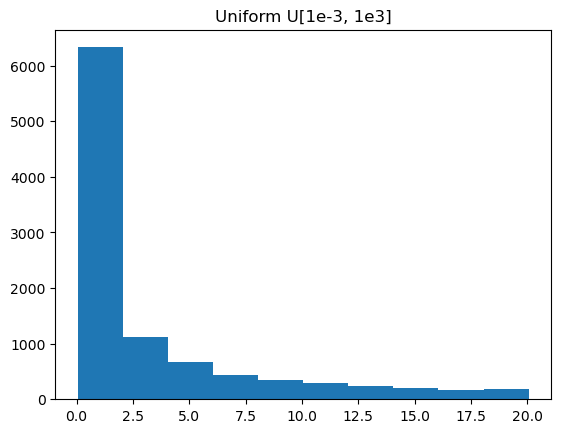

In [9]:
a, b, size = np.e**-3, np.e**3, 10000 
u = loguniform(a, b)
fig, ax = plt.subplots()
ax.hist(u.rvs(size))
ax.set_title("Uniform U[1e-3, 1e3]")
plt.show()

In [10]:
n_folds = 10
param_distributions = {'C':loguniform(1e-2, 1e2),
                       'gamma':loguniform(1e-2, 1e2)}

randomized_svc = SVC(kernel='rbf', probability=True)
randomized_clf = RandomizedSearchCV(estimator=randomized_svc, param_distributions=param_distributions, n_iter=25, scoring='neg_log_loss', n_jobs=-1, cv=n_folds, verbose=5)

In [11]:
%%time
randomized_clf.fit(X, y)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
CPU times: user 5.49 s, sys: 644 ms, total: 6.13 s
Wall time: 7min 46s


RandomizedSearchCV(cv=10, estimator=SVC(probability=True), n_iter=25, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1576b0f50>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1576b22d0>},
                   scoring='neg_log_loss', verbose=5)

In [12]:
print("The best CV estimator: {}".format(randomized_clf.best_estimator_))
print("The best CV score: {:.2f}".format(randomized_clf.best_score_))

The best CV estimator: SVC(C=10.696571279195355, gamma=0.1714121093949107, probability=True)
The best CV score: -0.22


#### Get the Sharpe ratio of GridSearch with neg_log_loss

In [13]:
def get_shape_ratio(mean_test_score, std_test_score):
    best_ratio = float('-inf')
    best_idx = -1
    for i in range(len(mean_test_score)):
        if std_test_score[i] != 0:
            ratio = mean_test_score[i] / std_test_score[i]
            if ratio > best_ratio:
                best_ratio = ratio
                best_idx = i
    
    print("Best Sharpe ratio={:4f}".format(best_ratio))
    print("With mean test score={:.4f} and std test score={:4f}".format(mean_test_score[best_idx], std_test_score[best_idx]))

get_shape_ratio(grid_clf.cv_results_['mean_test_score'], grid_clf.cv_results_['std_test_score'])

Best Sharpe ratio=-4.007693
With mean test score=-0.2048 and std test score=0.051099


#### Get the Sharpe ratio of GridSearch with accuracy

In [14]:
grid_accuracy_svc = SVC(kernel='rbf', probability=True)
grid_accuracy_clf = GridSearchCV(estimator=grid_accuracy_svc, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=n_folds, verbose=10)

In [15]:
%%time
grid_accuracy_clf.fit(X, y)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
CPU times: user 4.03 s, sys: 636 ms, total: 4.67 s
Wall time: 6min 49s


GridSearchCV(cv=10, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1, 10, 100]},
             scoring='accuracy', verbose=10)

In [16]:
print("The best CV estimator: {}".format(grid_accuracy_clf.best_estimator_))
print("The best CV score: {:.2f}".format(grid_accuracy_clf.best_score_))

The best CV estimator: SVC(C=1, gamma=0.1, probability=True)
The best CV score: 0.93


In [17]:
get_shape_ratio(grid_accuracy_clf.cv_results_['mean_test_score'], grid_accuracy_clf.cv_results_['std_test_score'])

Best Sharpe ratio=1092.616976
With mean test score=0.5007 and std test score=0.000458


#### Get the Sharpe ratio of RandomizedSearch

In [18]:
get_shape_ratio(randomized_clf.cv_results_['mean_test_score'], randomized_clf.cv_results_['std_test_score'])

Best Sharpe ratio=-5.158047
With mean test score=-0.2227 and std test score=0.043169


#### Get the Sharpe ratio of RandomizedSearch with accuracy

In [19]:
randomized_accuracy_svc = SVC(kernel='rbf', probability=True)
randomized_accuracy_clf = RandomizedSearchCV(estimator=randomized_accuracy_svc, param_distributions=param_distributions, n_iter=25, scoring='accuracy', n_jobs=-1, cv=n_folds, verbose=5)

In [20]:
%%time
randomized_accuracy_clf.fit(X, y)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
CPU times: user 4.51 s, sys: 763 ms, total: 5.27 s
Wall time: 7min 49s


RandomizedSearchCV(cv=10, estimator=SVC(probability=True), n_iter=25, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1576b0f50>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1576b22d0>},
                   scoring='accuracy', verbose=5)

In [21]:
print("The best CV estimator: {}".format(randomized_accuracy_clf.best_estimator_))
print("The best CV score: {:.2f}".format(randomized_accuracy_clf.best_score_))

The best CV estimator: SVC(C=14.643837948909159, gamma=0.09738061893308514, probability=True)
The best CV score: 0.93


In [22]:
get_shape_ratio(randomized_accuracy_clf.cv_results_['mean_test_score'], randomized_accuracy_clf.cv_results_['std_test_score'])

Best Sharpe ratio=1092.616976
With mean test score=0.5007 and std test score=0.000458
